In [ ]:
import pandas as pd

df = pd.read_csv('KG.csv')
df.head()

,Sno,Malware,Relation,Operating System,Time-Stamp
0,0,GANDCRAB,uses,WINDOWS,2018-07-24 08:57:20.0000000
1,1,EMOTET,uses,WINDOWS,2018-07-24 08:57:20.0000000
2,2,RIG EXPLOIT,uses,WINDOWS,2018-07-24 08:57:20.0000000
3,3,RIG,uses,WINDOWS,2018-07-24 08:57:20.0000000
4,4,RESPONDER,uses,WINDOWS,2018-07-24 08:57:20.0000000


In [ ]:
from langchain.graphs import Neo4jGraph

In [ ]:
# # Wait 60 seconds before connecting using these details, or login to https://console.neo4j.io to validate the Aura Instance is available
# NEO4J_URI=neo4j+s://9bf57c1c.databases.neo4j.io
# NEO4J_USERNAME=neo4j
# NEO4J_PASSWORD=HJnpf2wH2yE7xM5mfTWCjnZKDFgT3PLKHpOr2_Rz7v4
# AURA_INSTANCEID=9bf57c1c
# AURA_INSTANCENAME=Free instance

In [ ]:
NEO4J_URI="neo4j+s://9bf57c1c.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="HJnpf2wH2yE7xM5mfTWCjnZKDFgT3PLKHpOr2_Rz7v4"
AURA_INSTANCEID="9bf57c1c"
AURA_INSTANCENAME="Instance01"

graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
)

graph_schema = graph.structured_schema
print(graph_schema)

{'node_props': {'Malware': [{'property': 'name', 'type': 'STRING'}], 'OperatingSystem': [{'property': 'name', 'type': 'STRING'}]}, 'rel_props': {'RELATION': [{'property': 'type', 'type': 'STRING'}, {'property': 'timestamp', 'type': 'STRING'}]}, 'relationships': [{'start': 'Malware', 'type': 'RELATION', 'end': 'OperatingSystem'}], 'metadata': {'constraint': [], 'index': []}}


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [ ]:
from langchain_openai import ChatOpenAI
""
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
llm.invoke('Hi').pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
from langchain.chains import GraphCypherQAChain
chain = GraphCypherQAChain.from_llm(llm=llm, graph=graph, verbose=True, allow_dangerous_requests=True, validate_cypher=True,)

In [ ]:
result = chain.invoke('Count KEYMARBLE Malware.')



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Malware {name: "KEYMARBLE"}) RETURN COUNT(m)

Full Context:
[{'COUNT(m)': 0}]

> Finished chain.


In [ ]:
print(result['result'])

I don't know the answer.


In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
import operator
from typing import Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

In [ ]:
class MyState(MessagesState):
    user_query: str
    cypher_query: str
    results: list
    formatted_result: str
    direction: str
    evaluation: dict
    final_output: str
    opt_result: str
    reason: str
    attempts: int
    retry_count: int

In [ ]:
def director(state: MyState):
    user_query = state['user_query']

    prompt = f"""
    You are an intelligent assistant. Based on the following user input, decide whether to respond directly or fetch information from an external source.

    The external source is a Graph Database which contains Knowledge Graph about MALWARES targetting to OPERATING SYSTEMS at DIFFERENT TIMESTAMPS.

    But the external source does not contain information about MALWARES or OPERATING SYSTEM.

    User Input: "{user_query}"

    If you can answer directly, respond with "direct_response".
    If you need to fetch information, respond with "fetch_data".
    """

    direction = llm.invoke([SystemMessage(prompt)])

    return {"direction": direction.content, "messages": direction}

In [ ]:
def fact_answer(state: MyState):
    user_query = state['user_query']
    reason = state.get('reason', '')

    prompt = f"""You are an intelligent assistant. Based on the following user input, answer it.
    Your answer must be concise and precise. Modify the answer according to reason if reason is there, Reason: {reason}.
    """

    response = llm.invoke([SystemMessage(prompt)] + [HumanMessage(f"{user_query}")])

    return {"formatted_result": response, "messages": response}

In [ ]:
def get_graph_schema():
    """Fetches node labels, relationship types, and properties from Neo4j."""
    # query = """
    # CALL db.schema.visualization() YIELD nodes, relationships
    # RETURN nodes, relationships
    # """
    # result = graph.query(query)
    return graph.structured_schema

In [ ]:
import re

def extract_cypher_query(text):

    match = re.search(r"```cypher\n(.*?)\n```", text, re.DOTALL)

    if match:
        cypher_query = match.group(1)
    else:
        cypher_query = "No Cypher query found."

    return cypher_query

In [ ]:
def generate_cypher_query(state: MyState):
    """Node to generate cypher query"""

    schema_info = get_graph_schema()

    system_msg = f"""
    You are an expert in Cypher query generation. The Neo4j database has the following schema:
    {schema_info}.

    The query must return a string value using toString() when it is datetime.
    """

    user_query = state['user_query']

    response = llm.invoke([SystemMessage(system_msg)] + [HumanMessage(f"Generate Cypher Query for the following: {user_query}")])

    cypher_query = extract_cypher_query(response.content)

    return {"cypher_query": cypher_query, "messages": response}

In [ ]:
import random

def execute_cypher_query(state: MyState):
    """Execute the Cypher query against Neo4j and randomly select up to 10 results."""
    try:
        cypher_query = state["cypher_query"]
        results = graph.query(cypher_query)

        # If there are more than 10 results, randomly select 10
        if isinstance(results, list):
            if len(results) > 10:
                results = random.sample(results, 10)

        return {"results": results}

    except Exception as e:
        print(f"Error executing cypher query: {str(e)}")
        # Return empty results on error
        return {"results": str(e)}

In [ ]:
def update_attempts_node(state: MyState):
    # Increment and update attempts
    attempts = state.get("attempts", 0)
    attempts += 1
    state["attempts"] = attempts
    print(f"Attempt: {attempts}")
    return state

def condition(state: MyState):
    attempts = state.get("attempts", 0)  # fallback to 0 if not set
    formatted_result = state.get("formatted_result", "")

    if attempts < 3 and formatted_result == "No results found, revising the query might help.":
        return "generate_cypher_query"
    else:
        if attempts >= 3:
            state["formatted_result"] = "Unable to find results after multiple query attempts. Please try rephrasing your question."
            state["attempts"] = 0  # reset after max retries
        return "evaluator"

In [ ]:
def format_results(state: MyState):
    """Format the results or provide reasoning if no results found."""
    results = state.get("results", None)
    reason = state.get('reason', '')

    # Prepare system message
    system_msg = f"""You are answering expert from the given Neo4j query results.

    The answer must be properly formatted.

    Answer based on the following results:
    {results}.

    Modify the answer according to reason if reason is there, Reason: {reason}.

    Your answer must be concise and precise. If it's a Yes/No Question, just answer Yes/No.
    Don't answer anything in a bullet format, if there are multiple answers, answer as a list like [...,...,...,...]
    And just write answer, no preamble.
    """

    if results:
        # If results are found, format the result and update state
        formatted_result = llm.invoke([SystemMessage(system_msg)] + [HumanMessage("Answer!!!")])
        state["formatted_result"] = formatted_result.content
        state["messages"] = formatted_result
        return state
    else:
        # No results → increment attempts and return reasoning
        state = update_attempts_node(state)  # Increment attempt count

        # Check if attempts exceeded the limit
        attempts = state.get("attempts", 0)
        if attempts >= 3:
            state["formatted_result"] = "Unable to find results after multiple query attempts. Please try rephrasing your question."
            state["attempts"] = 0  # Reset attempts after max retries
        else:
            # If attempts are below 3, return a generic message
            state["formatted_result"] = "No results found, revising the query might help."

        return state

In [ ]:
def dir_condition(state: MyState):
    if state.get('direction') == "direct_response":
        return "fact_answer"
    else:
        return "generate_cypher_query"

In [ ]:
def evaluator(state: MyState):
    """Evaluates the response given by the agents."""
    response = state['formatted_result']

    evaluation = {
        "quality_score": 0.0,
        "review_notes": "",
        "passed": False,
    }

    if not response:
        evaluation.update({
            "review_notes": "No response was generated.",
            "quality_score": 0.0,
            "passed": False,
        })
    elif isinstance(response, str):
        length = len(response.split())
        evaluation.update({
            "review_notes": f"Response contains {length} words.",
            "quality_score": min(1.0, length / 50),  # 50+ words = high-quality assumption
            "passed": length > 5,
        })
    elif isinstance(response, list):
        evaluation.update({
            "review_notes": f"Response is a list with {len(response)} items.",
            "quality_score": min(1.0, len(response) / 3),  # Score based on result richness
            "passed": len(response) > 0,
        })
    else:
        evaluation.update({
            "review_notes": "Unrecognized response format.",
            "quality_score": 0.3,
            "passed": False,
        })

    # print("[Evaluator] Evaluation complete:", evaluation)

    return {'evaluation': evaluation}

In [ ]:
def optimizer(state: MyState):
    # Update the retry count
    retry_count = state.get("retry_count", 0)
    retry_count += 1
    state["retry_count"] = retry_count
    print(f"[Optimizer] Retry attempt: {retry_count}")

    evaluation = state.get('evaluation', {})
    original_response = state.get('formatted_result', '')
    final_output = ""
    reason = ""

    if not evaluation.get("passed", False):
        final_output = f"⚠️ The answer may be incomplete or unclear. Here's what was generated:\n\n {original_response}"
        opt_result = "low_quality"
    else:
        score = evaluation.get("quality_score", 0.0)
        if score < 0.25 and retry_count < 3:
            # Print reasoning for low-quality score
            reason = llm.invoke([SystemMessage(f'Give Reasoning in 20 words for improvement for the quality score: {score}\nOriginal Response: {original_response}')])
            opt_result = "retry"
        elif score < 0.25 and retry_count >= 3:
            # Max retries reached - provide final message
            final_output = f"After multiple attempts, we couldn't generate a higher quality response. Here's the original:\n\n{original_response}"
            opt_result = "complete"
            # Reset retry count after max retries
            state["retry_count"] = 0
        else:
            system_msg = "Optimize and enhance the result. Keep it accurate."
            final_output = llm.invoke([SystemMessage(system_msg)] + [HumanMessage(f"Original Response: {original_response}")])
            opt_result = "complete"
            # Reset retry count when complete
            state["retry_count"] = 0

    # Update state with necessary keys
    state['final_output'] = final_output
    state['opt_result'] = opt_result
    state['reason'] = reason
    state['message'] = reason

    return state

In [ ]:
def optimizer_condition(state: MyState):
    result = state.get("opt_result")
    print(f"[OptimizerCondition] Result: {result}")

    if result == "retry":
        return "director"  # Retry allowed
    elif result == "low_quality" or result == "complete":
        return END
    else:
        return END

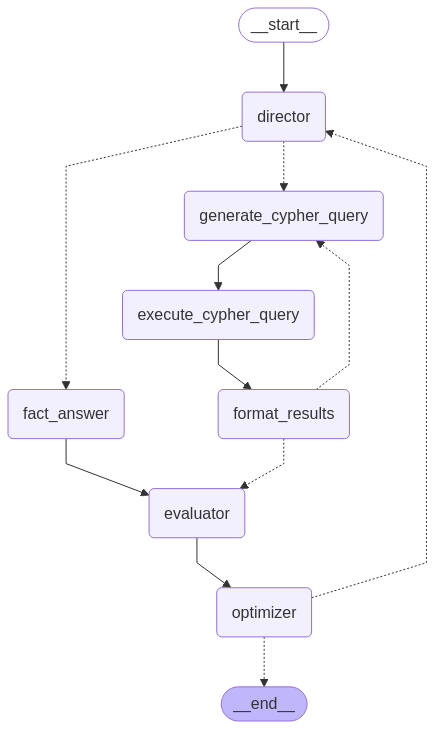

In [ ]:
builder = StateGraph(MyState)
builder.add_node("director", director)
builder.add_node("fact_answer", fact_answer)
builder.add_node("generate_cypher_query", generate_cypher_query)
builder.add_node("execute_cypher_query", execute_cypher_query)
builder.add_node("format_results", format_results)
builder.add_node("evaluator", evaluator)
builder.add_node("optimizer", optimizer)

builder.add_edge(START, "director")
builder.add_conditional_edges(
    "director",
    dir_condition,
    {
        "generate_cypher_query": "generate_cypher_query",
        "fact_answer": "fact_answer",
    }
)
builder.add_edge("generate_cypher_query", "execute_cypher_query")
builder.add_edge("execute_cypher_query", "format_results")
builder.add_conditional_edges(
    "format_results",
    condition,
    {
        "generate_cypher_query": "generate_cypher_query",
        "evaluator": "evaluator",
    }
)
builder.add_edge("fact_answer", "evaluator")
builder.add_edge("evaluator", "optimizer")
builder.add_conditional_edges(
    "optimizer",
    optimizer_condition,
    {
        "director": "director",
        END: END,
    }
)

memory = MemorySaver()
agent = builder.compile(checkpointer = memory)

display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
instruction = "Which malware families share the same target operating system as EMOTET?"

msg = [HumanMessage(content=instruction)]
thread = {"configurable": {"thread_id": "4"}}
response = agent.invoke({"user_query": msg, "messages": msg}, thread)

[Optimizer] Retry attempt: 1
[OptimizerCondition] Result: complete


In [ ]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

Which malware families share the same target operating system as EMOTET?
================================== Ai Message ==================================

fetch_data
================================== Ai Message ==================================

```cypher
MATCH (m1:Malware {name: 'EMOTET'})-[:RELATION]->(os:OperatingSystem)<-[:RELATION]-(m2:Malware)
WHERE m1.name <> m2.name
RETURN DISTINCT m2.name
```
================================== Ai Message ==================================

['ANGLER EXPLOIT', 'DEALERSCHOICE', 'ZLIB', 'MIRAGEFOX', 'URSNIF DATA EXCHANGE', 'JAFF', 'DROIDJACK', 'VPNFILTER', 'FRUITFLY', 'BADRABBIT']


In [ ]:
print(response['cypher_query'])

MATCH (m1:Malware {name: 'EMOTET'})-[:RELATION]->(os:OperatingSystem)<-[:RELATION]-(m2:Malware)
WHERE m1.name <> m2.name
RETURN DISTINCT m2.name


In [ ]:
qa = pd.read_csv('200_mixed_questionnaire.csv')

In [ ]:
qa['Type'].unique()

array(['Objective', 'Factual', 'Reasoning'], dtype=object)

In [ ]:
# Filter and create lists for each type
qa_objective = list(zip(qa[qa['Type'] == 'Objective']['Question'], qa[qa['Type'] == 'Objective']['Answer']))
qa_factual = list(zip(qa[qa['Type'] == 'Factual']['Question'], qa[qa['Type'] == 'Factual']['Answer']))
qa_reasoning = list(zip(qa[qa['Type'] == 'Reasoning']['Question'], qa[qa['Type'] == 'Reasoning']['Answer']))

In [ ]:
import os
from bert_score import BERTScorer

# Set your Hugging Face token as an environment variable
os.environ["HF_TOKEN"] = "hf_XXXXXXXXXXXXXXXXXXXXXXXXX"  # Replace with your actual token

# Then initialize BERTScorer
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

/home/honors/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-04-24 00:01:23.258299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745433083.274513   53228 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745433083.279367   53228 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745433083.292129   53228 computation_placer.cc:177] computation placer already registered. Please ch

In [ ]:
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support
from langchain.schema import HumanMessage
from bert_score import BERTScorer
import uuid  # <-- to generate unique thread IDs

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Initialize BERTScore
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

# Lists to store scores
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
precision_list, recall_list, f1_list = [], [], []
bertscore_p, bertscore_r, bertscore_f1 = [], [], []

for question, expected_answer in qa_reasoning:
    msg = [HumanMessage(content=question)]

    # Generate a unique thread ID
    thread_id = str(uuid.uuid4())
    thread = {"configurable": {"thread_id": thread_id}}

    response = agent.invoke({"user_query": msg, "messages": msg}, thread)

    generated_answer = response["formatted_result"]
    if not isinstance(generated_answer, str):
        generated_answer = response["formatted_result"].content

    # Compute ROUGE scores
    scores = scorer.score(expected_answer, generated_answer)
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

    # Compute BERTScore
    P, R, F1 = bert_scorer.score([generated_answer], [expected_answer])
    bertscore_p.append(P.item())
    bertscore_r.append(R.item())
    bertscore_f1.append(F1.item())

    print(f"Question: {question}")
    print(f"Generated Answer: {generated_answer}")
    print(f"Thread ID: {thread_id}")
    print(f"Rouge-L Score: {scores['rougeL'].fmeasure:.4f}")
    print(f"BERTScore F1: {F1.item():.4f}\n")

    # Token-based metrics
    expected_tokens = set(expected_answer.split(", "))
    generated_tokens = set(generated_answer.split())

    tp = len(expected_tokens & generated_tokens)
    fp = len(generated_tokens - expected_tokens)
    fn = len(expected_tokens - generated_tokens)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Optimizer] Retry attempt: 1
[OptimizerCondition] Result: low_quality
Question: TAJMAHAL and CARROTBALL have no overlapping timestamps. What might this indicate about their operations?
Generated Answer: The lack of overlapping timestamps between TAJMAHAL and CARROTBALL might indicate that their operations are separate and independent from each other. This could suggest that they occur in different time frames or serve different functions that do not require them to operate simultaneously.
Thread ID: 36adfeb3-8192-4337-8950-3b030d96b88b
Rouge-L Score: 0.3099
BERTScore F1: 0.4601

Attempt: 1
[Optimizer] Retry attempt: 1
[OptimizerCondition] Result: retry
[Optimizer] Retry attempt: 2
[OptimizerCondition] Result: low_quality
Question: CHOPPER and AVENGER have no overlapping timestamps. What might this indicate about their operations?
Generated Answer: The lack of overlapping timestamps between CHOPPER and AVENGER could indicate that they operate independently or in distinct phases, possibl

In [ ]:
# Compute average scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)
avg_bertscore_p = sum(bertscore_p) / len(bertscore_p)
avg_bertscore_r = sum(bertscore_r) / len(bertscore_r)
avg_bertscore_f1 = sum(bertscore_f1) / len(bertscore_f1)

print("\n===== EVALUATION RESULTS =====")
print(f"Avg ROUGE-1: {avg_rouge1:.4f}")
print(f"Avg ROUGE-2: {avg_rouge2:.4f}")
print(f"Avg ROUGE-L: {avg_rougeL:.4f}")
print(f"Avg Custom Precision: {avg_precision:.4f}")
print(f"Avg Custom Recall: {avg_recall:.4f}")
print(f"Avg Custom F1 Score: {avg_f1:.4f}")
print(f"Avg BERTScore Precision: {avg_bertscore_p:.4f}")
print(f"Avg BERTScore Recall: {avg_bertscore_r:.4f}")
print(f"Avg BERTScore F1: {avg_bertscore_f1:.4f}")


===== EVALUATION RESULTS =====
Avg ROUGE-1: 0.2862
Avg ROUGE-2: 0.0461
Avg ROUGE-L: 0.2152
Avg Custom Precision: 0.0690
Avg Custom Recall: 0.0586
Avg Custom F1 Score: 0.0617
Avg BERTScore Precision: 0.0947
Avg BERTScore Recall: 0.1706
Avg BERTScore F1: 0.1302


# Potential Errors:
1. Hallucination
2. Data fed incorrectly in GraphDB (Neo4J)
3. BERTScore calculation code is wrong